In [54]:
"""
Copyright 2018
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import numpy as np
import keras

from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding1D
from keras.layers import MaxPooling1D, Lambda
from keras.layers.convolutional import UpSampling2D, Conv1D, Cropping1D
from keras.models import Sequential, Model
from keras.layers import MaxPooling1D, concatenate, Add
import keras.backend as K


import keras.utils
from keras.engine.topology import Layer
class Bias(Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(input_shape[-1],),
                                        initializer="zeros",
                                        name='bias',
                                        regularizer=None,
                                        constraint=None)
        super(Bias, self).build(input_shape)
        
    def call(self, inputs):
        outputs = K.bias_add(
                inputs,
                self.bias)
        return outputs
    
    def compute_output_shape(self, input_shape):
        return input_shape


keras.layers.Bias = Bias

def partial_convolution(input_, mask, filters, shape, stride, activation):
    convolution_layer = Conv1D(filters, shape, strides=stride, use_bias=False,
                               padding="same")
    
    mask_sum_layer = Conv1D(filters, shape, strides=stride, 
                                  padding="same", 
                                  weights=[np.ones((shape[0], input_.shape[-1], filters)),
                                           np.zeros((filters,))])
    
    mask_sum_layer.trainable = False
    
    mask_sum = mask_sum_layer(mask)
    
    new_mask = Lambda(lambda x: K.clip(x, 0, 1))(mask_sum)
    
    output = convolution_layer(keras.layers.multiply([mask, input_]))
    
    inv_sum = Lambda(lambda x: filters * shape[0] / (.0001 + x))(mask_sum) 
    
    output = keras.layers.multiply([output, inv_sum])
    
    output = Bias()(output)
    
    output = activation(output)
    
    return output, new_mask

def normal_convolution(input_, mask, filters, shape, stride, activation):
    convolution_layer = Conv1D(filters, shape, strides=stride,
                               padding="same")
    
    output = convolution_layer(input_)
    
    output = activation(output)
    
    return output, mask

def residual_block(input_, mask):
    output, new_mask = normal_convolution(input_, mask, 512, (3,), 1, Activation("relu"))
    output, new_mask = normal_convolution(output, new_mask, 512, (3,), 1, Activation("relu"))
    output, new_mask = normal_convolution(output, new_mask, int(input_.shape[-1]), (3,), 1, Activation("relu"))
    output = keras.layers.Add()([output, input_])
    new_mask = keras.layers.Add()([mask, new_mask])
    new_mask = Lambda(lambda x: K.clip(x, 0, 1))(new_mask)
    return output, new_mask
    

def sequence_unet(patch_size=256, dim=36):
    
    global sequence_unet_input
    global sequence_unet_input_mask
    input_ = Input((patch_size, dim))
    sequence_unet_input = input_
    input_mask = Input((patch_size, dim))
    sequence_unet_input_mask = input_mask
    skips = []
    output = input_
    mask = input_mask
    for shape, filters in zip([7, 5, 5, 3, 3, 3, 3, 3], [64, 128, 256, 256, 256, 256, 256, 256]):
        skips.append((output, mask))
        print(output.shape)
        output, mask = partial_convolution(output, mask, filters, (shape,), 2,
                                           Activation("relu"))
        if shape != 7:
            output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [256, 256, 256, 256, 256, 128, 64, dim]):
        output = keras.layers.UpSampling1D()(output)
        mask = keras.layers.UpSampling1D()(mask)
        skip_output, skip_mask = skips.pop()
        output = concatenate([output, skip_output], axis=2)
        mask = concatenate([mask, skip_mask], axis=2)
        
        if filters != dim:
            activation = keras.layers.LeakyReLU(.2)
        else:
            activation = Activation("linear")
        output, mask = partial_convolution(output, mask, filters, (shape,), 1, activation)
        #output, mask = residual_block(output, mask)
        if filters != dim:
            output = BatchNormalization()(output)
    assert len(skips) == 0
    return Model([input_, input_mask], [output])

def discriminator_network(length, fulldata_dim):
    known_values = Input((length, fulldata_dim))
    mask = Input((length, fulldata_dim))
    prediction = Input((length, fulldata_dim))
    
    known_values_filt = keras.layers.Multiply()([known_values, mask])
    x = keras.layers.concatenate([known_values_filt, prediction])
    x = Conv1D(64, 5, strides=2, activation="relu")(x)
    x = Conv1D(64, 5, strides=2, activation="relu")(x)
    x1 = Conv1D(128, 5, strides=2, activation="relu")(x)
    x = Conv1D(128, 5, strides=2, activation="relu")(x1)
    x = Conv1D(256, 5, strides=2, activation="relu")(x)

    x = Flatten()(x)
    x = Dense(1)(x)
    
    local = Conv1D(1, 5)(x1)
    
    disc_network = Model([known_values, mask, prediction], [x, local])
    
    
    def disc_network_loss(placeholder, model_out):
        
        
        discriminator_output, local_output = disc_network([sequence_unet_input, sequence_unet_input_mask, model_out])
        
        
        return K.mean(local_output[:, :, 0], axis=1) + discriminator_output + 25 * K.mean((sequence_unet_input - model_out)**2)
        
    disc_network.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.adam())
    
    
    return disc_network, disc_network_loss



def pad_to_patch_size(image, mask, patch_size=256):
    #Network only accepts square images with size as a multiple of 256.
    #Use the mask to make sure that the output only depends on the valid rectangle.
    network_input = np.zeros((1, patch_size, patch_size, 3))
    network_mask = np.zeros((1, patch_size, patch_size, 3))

    network_input[:, :image.shape[1], :image.shape[2]] = image
    network_mask[:, :mask.shape[1], :mask.shape[2]] = mask

    return network_input, network_mask


def compute_patch_size_to_fit(z):
    num_patches = (max(z.shape[1], z.shape[2]) - 1) // 256 + 1
    return 256 * num_patches

In [2]:
class Game:
    def __init__(self, name, use_vae, num_controls, num_obs_dims, experience_file, vae_file = None,
                unet_length = 256):
        self.name = name
        self.use_vae = use_vae
        self.num_controls = num_controls
        self.num_obs_dims = num_obs_dims
        self.experience_file = experience_file
        self.vae_file = vae_file
        self.fulldata_dim = num_controls + num_obs_dims + 1
        self.unet_length = unet_length
game = Game("CarRacing-v0", True, 3, 32, "more_runs.pickle", "vae_cnn_mnist.h5", 256)
#game = Game("BipedalWalker-v2", False, 4, 24, "some_walks.pickle", None, 256)

In [55]:
network = sequence_unet(game.unet_length, game.fulldata_dim)
disc_network, disc_network_loss = discriminator_network(256, game.fulldata_dim)

(?, 256, 36)
(?, 128, 64)
(?, 64, 128)
(?, 32, 256)
(?, 16, 256)
(?, 8, 256)
(?, 4, 256)
(?, 2, 256)


In [4]:
import pickle
class Run:
    def __init__(self):
        self.obs_l = []
        self.reward_l = []
        self.action_l = []
some_runs = pickle.load(open(game.experience_file, "rb"))


In [5]:
for run in some_runs:
    run.obs_l = np.array(run.obs_l)

In [6]:
K.zeros

<function keras.backend.tensorflow_backend.zeros(shape, dtype=None, name=None)>

In [7]:
import vae
if(game.use_vae):
    vae.vae.load_weights(game.vae_file)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   1568        encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 22, 22, 64)   32832       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 10, 10, 128)  131200      conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [8]:
import cv2
decoded = vae.decoder.predict(some_runs[20].obs_l[0])
for im in decoded:
    cv2.imshow("hi", im)
    if cv2.waitKey(10) != -1:
        break

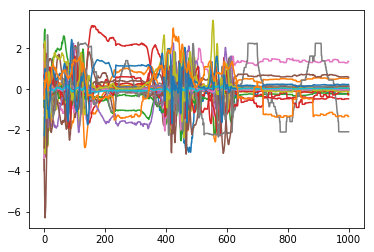

In [9]:
import matplotlib.pyplot as plt
plt.plot(some_runs[2000].obs_l[0])
plt.show()

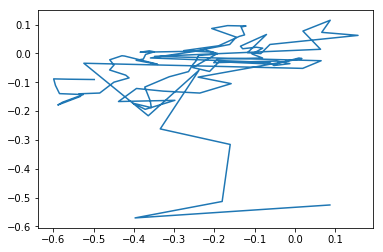

In [10]:
obs_l = some_runs[41].obs_l[0]
plt.plot(obs_l[:100, 0], obs_l[:100, 10])
plt.show()

In [11]:
from noise import pnoise1
def makeNoise(l):
    start = np.random.random() * 10000
    out = []
    for _ in range(l):
        a = pnoise1(_ / 140 + start, 5)
        out.append(a)
    return np.array(out)
def mask():
    m1 = makeNoise(256) > 0
    m1 = m1.reshape (256, 1)
    m1 = np.repeat(m1,3, 1)
    
    m2 = makeNoise(256) > 0
    m2 = m2.reshape (256, 1)
    m2 = np.repeat(m2, 32, 1)
    
    m3 = makeNoise(256) > 0
    m3 = m3.reshape (256, 1)
    #m3 = np.repeat(m, 36, 1)
    #m[:, :3] = 1
    return np.concatenate([m1, m2, m3], -1)

def mask():
    m = makeNoise(256) > 0
    m = m.reshape (256, 1)
    m = np.repeat(m, game.fulldata_dim, 1)
    m[:, :game.num_controls] = 1
    return m

In [12]:
full_data = [
    np.concatenate([
        r.action_l[:r.obs_l[0].shape[0]], 
        r.obs_l[0], 
        np.arctan(np.expand_dims(r.reward_l, 1))
    ], axis=1) 
    for r in some_runs
]
for i in range(len(full_data)):
    if len(full_data[i]) <= 256:
        
        full_data[i] = np.concatenate([
            full_data[i], 
            np.repeat(full_data[i][-1:], 300 - len(full_data[i]), axis=0)
        ], axis=0)
        
        
print(len(full_data))

10000


In [13]:
full_data = [
    np.concatenate([
        r.action_l[:r.obs_l[0].shape[0]], 
        r.obs_l[0], 
        np.expand_dims(r.reward_l, 1)
    ], axis=1) 
    for r in some_runs
    if len(r.reward_l) > 256
]
print(len(full_data))

9996


In [14]:
data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
masks = np.array([mask() for _ in range(len(data_cropped))])

In [57]:
network.compile(loss=[disc_network_loss], optimizer=keras.optimizers.adam(), metrics=[keras.losses.mse])

In [58]:
"""for _ in range(280):
    data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
    data_cropped = np.array([f[start:256 + start] for f, start in zip(full_data, data_starts)])
    masks = np.array([control_mask(128)[0] for _ in range(len(data_cropped))])
    
    network.fit([data_cropped[:-200], masks[:-200]], data_cropped[:-200], validation_data=
               ([data_cropped[-200:], masks[-200:]], data_cropped[-200:]))"""

import random
modelRuns = []
for _ in range(200080):
    modelRuns.append(modelRun())
    for __ in range(100):
        idx = np.random.randint(0, len(full_data) - 200, 128)
        #print(idx)
        round_data = [full_data[i] for i in idx]
        data_starts = [np.random.randint(0, len(ar) - 256) for ar in round_data]
        data_cropped = np.array([f[start:256 + start] for f, start in zip(round_data, data_starts)])
        masks = np.array([
            mask() if random.random() < .5 else control_mask(random.randint(100, 150)) [0]
            for _ in range(len(data_cropped))])

        network.train_on_batch([data_cropped, masks], data_cropped)

        disc_input = network.predict([data_cropped, masks])
        disc_input = np.concatenate([disc_input, data_cropped], 0)

        disc_output = np.concatenate([np.ones((128, 1)), np.zeros((128, 1))])
        local_output = np.concatenate([np.ones((128, 25, 1)), np.zeros((128, 25, 1))])

        disc_network.train_on_batch([np.repeat(data_cropped, 2, 0), np.repeat(masks, 2, 0), disc_input], [disc_output, local_output])


Track generation: 1143..1433 -> 290-tiles track
Track generation: 1134..1422 -> 288-tiles track
Track generation: 1060..1329 -> 269-tiles track
Track generation: 1155..1448 -> 293-tiles track
Track generation: 1339..1677 -> 338-tiles track
Track generation: 1168..1464 -> 296-tiles track
Track generation: 1061..1338 -> 277-tiles track
Track generation: 1228..1539 -> 311-tiles track


KeyboardInterrupt: 

In [55]:
final_val_loss=.0165

In [117]:
mask

array([[[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]],

       [[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.]]])

In [42]:
data_out = network.predict([data_cropped, masks])

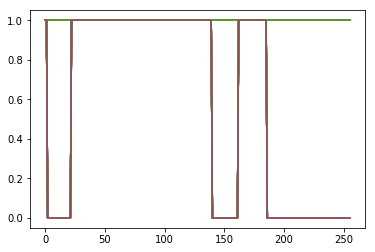

In [43]:
import cv2
def watch(fulld):
    
    decoded = vae.decoder.predict(fulld[:, 3:35])
    for im in decoded:
        cv2.imshow("hi", im)
        if cv2.waitKey(10) != -1:
            break
plt.plot(masks[-1])
plt.show()
if(game.use_vae):
    watch(data_cropped[-1])


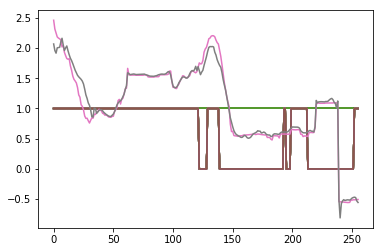

In [44]:
j = np.random.randint(0, 100)

plt.plot(masks[j])
plt.plot(data_cropped[-j,:,  -10])
plt.plot(data_out[-j,:,  -10])
plt.show()


In [45]:
watch(data_cropped[-j])
watch(data_out[-j])

In [26]:
def control_mask(len_init):
    out = np.concatenate([np.ones(len_init), np.zeros(256 - len_init)])
    out = out.reshape(1, 256, 1)
    out = np.repeat(out, game.fulldata_dim, 2)
    out[:,:, :game.num_controls] = 1
    return out

In [27]:
def apply_action(full_data, len_init, action):
    out = full_data.copy()
    
    out[:, len_init:, :game.num_controls] = np.array(action).reshape(len(out), -1, game.num_controls)
    return out

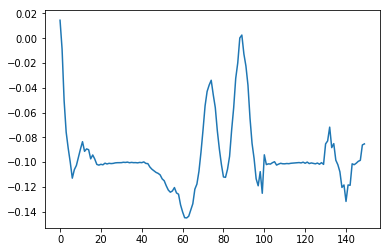

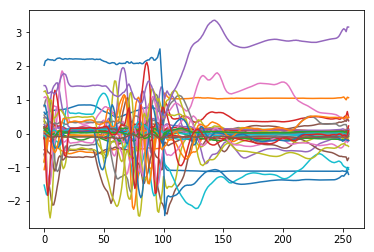

In [46]:

n = 101
control_out = network.predict([apply_action(data_cropped[-n:-n + 1], 100, [-1, 1, 0]), control_mask(100)])
watch(control_out[0, :256])
plt.plot(control_out[0, 0:150, -1])
score8 = np.sum(control_out[0, 100:115, -1])
score8
plt.show()
plt.plot(control_out[0])
plt.show()

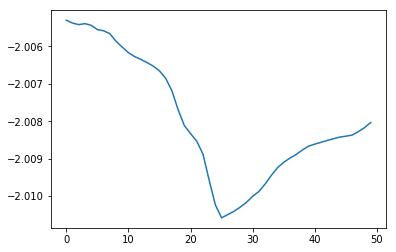

In [47]:
def score(full_data, len_init, action, do_watch=False):
    
    network_out = network.predict([
        apply_action(full_data, len_init, action),
        np.repeat(control_mask(len_init), len(np.reshape(action, (-1, 1, game.num_controls))), 0)
    ])
    if(do_watch):
        watch(network_out[0, len_init:])
        plt.plot(network_out[0, :, -1])
        plt.show()
    score = np.sum(network_out[:, len_init:len_init + 20, -1], axis=1)
    return score
plt.plot([score(data_cropped[-n:-n + 1], 100, [ctrl,  0, 1]) for ctrl in np.linspace(-1, 1, 50)])
plt.show()


In [48]:
import noise
import gym
import matplotlib.pyplot as plt
import numpy as np




env = gym.make(game.name)
from pyglet import gl
import cProfile
_ = env.reset()


Track generation: 1172..1469 -> 297-tiles track


In [31]:
env.action_space.sample()

array([0.09762701, 0.71518934, 0.60276335], dtype=float32)

In [32]:
env.action_space.low

array([-1.,  0.,  0.], dtype=float32)

In [49]:
def makeActionArray():
    start = np.random.random(4) * 10000
    out = []
    for _ in range(2000):
        action = [ 1.7 * pnoise1(_ / 200 + start_i, 5) for start_i in start]
        out.append(action)
    return np.array(out)

def choose_action(state, len_init):
    candidate_actions = [env.action_space.sample() for _ in range(20)]
    #for ac in candidate_actions:
     #   ac[2] = 0
    
    scores = score(
        np.repeat(np.expand_dims(state, 0),len(candidate_actions), 0), 
        len_init, candidate_actions
    ) 
    if(np.random.random() < .0):
        score(np.expand_dims(state, 0), len_init, candidate_actions[np.argmax(scores):np.argmax(scores) + 1], do_watch=True)
    
    return candidate_actions[np.argmax(scores)]

In [50]:
choose_action(data_cropped[-n], 100)

array([-0.5480086,  0.2390943,  0.7995314], dtype=float32)

In [53]:
def modelRun(encoded=False):
    _ = env.reset()
    done = False
    run = Run()
    i = 0
    
    def encode(obs):
        if game.use_vae:
            return vae.encoder.predict(np.array(obs) / 255.)[0]
        else:
            return obs
    
    
    while not done:
        if i == 0:
            full_state = np.zeros((256, game.fulldata_dim))
        elif i < 128:
            full_state = np.concatenate([
                run.action_l, 
                encode(run.obs_l), 
                np.expand_dims(run.reward_l, 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((256 - i, game.fulldata_dim))
            ])
        else: 
            full_state = np.concatenate([
                run.action_l[-128:], 
                encode(run.obs_l[-128:]), 
                np.expand_dims(run.reward_l[-128:], 1)
            ], axis=1) 
            full_state = np.concatenate([
                full_state,
                np.zeros((128, game.fulldata_dim))
            ])
        action = choose_action(full_state, np.min([i, 128]))
        #print(run.reward_l[-1:], action, i,  end="                  \r")
        i += 1
        obs, reward, done, _ = env.step(action)
        run.action_l.append(action)
        
        run.obs_l.append(obs)
        run.reward_l.append(reward)
        #if (len(run.reward_l) % 5 == 0):
        env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

run = modelRun()

Track generation: 1123..1415 -> 292-tiles track


KeyboardInterrupt: 

In [135]:
def policy_network(length, fulldata_dim, action_dim):
    input_ = Input((length, fulldata_dim))
    x = Conv1D(64, 5, strides=2, activation="relu")(input_)
    x = Conv1D(128, 5, strides=2, activation="relu")(x)
    x = Conv1D(256, 5, strides=2, activation="relu")(x)
    x = Conv1D(256, 5, strides=2, activation="relu")(x)
    x = Conv1D(512, 5, strides=2, activation="relu")(x)
    x = keras.layers.UpSampling1D()(x)
    x = Conv1D(256, 4, padding="same", activation="relu")(x)
    x = keras.layers.UpSampling1D()(x)
    x = Conv1D(256, 4, padding="same", activation="relu")(x)
    x = keras.layers.UpSampling1D()(x)
    x = Conv1D(256, 4, padding="same", activation="relu")(x)
    x = keras.layers.UpSampling1D()(x)
    x = Conv1D(128, 4, padding="same", activation="relu")(x)
    x = keras.layers.UpSampling1D()(x)
    #x = Conv1D(128, 4, padding="same", activation="relu")(x)
    #x = keras.layers.UpSampling1D()(x)
    #x = Conv1D(128, 4, padding="same", activation="relu")(x)
    #x = keras.layers.UpSampling1D()(x)
    x = Conv1D(action_dim, 4, padding="same", activation="tanh")(x)
    x = keras.layers.UpSampling1D()(x)
    x = keras.layers.UpSampling1D()(x)
    policy_network = Model([input_], [x])
    #policy_network.summary()
    mask = Input((256, fulldata_dim))
    policy_train_network = Model([input_, mask], [concatenate([input_, x], axis=2)])
    
    def policy_network_loss(placeholder, model_out):
        actions = model_out[:, :, -action_dim:]
        state = model_out[:, :, :-action_dim]
        
        predicted_result_part = K.concatenate([
            actions,
            K.zeros_like(state)[:, :, :-action_dim]
        ], -1)
        print(predicted_result_part.shape)
        predictor_input = K.concatenate([state, predicted_result_part], -2)
        print(predictor_input.shape)
        print(mask.shape)
        predictor_output = network([predictor_input, mask])
        print(predictor_output.shape)
        score = predictor_output[:, 128:200, fulldata_dim - 1 ]
        return -K.sum(score, axis=1)
        
    policy_train_network.compile(loss=policy_network_loss, optimizer=keras.optimizers.adam(lr=.0001))
    
    
    return policy_network, policy_train_network
policy_network, policy_train_network = policy_network(128, game.fulldata_dim, game.num_controls)

(?, 128, 36)
(?, 256, 36)
(?, 256, 36)
(?, 256, 36)


In [101]:
data_starts = [np.random.randint(0, len(ar) - 256) for ar in full_data]
data_cropped = np.array([f[start:128 + start] for f, start in zip(full_data, data_starts)])
masks = np.array([control_mask(128)[0] for _ in range(len(data_cropped))])

policy_train_network.fit([data_cropped, masks], data_cropped)

Epoch 1/1
2144/9996 [=====>........................] - ETA: 7s - loss: -6.5013

KeyboardInterrupt: 

In [ ]:
control = policy_network.predict(data_cropped)

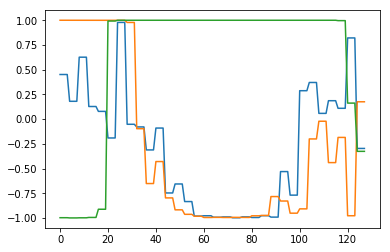

In [59]:
plt.plot(control[1])

In [151]:
def modelRun(encoded=False):
    _ = env.reset()
    done = False
    run = Run()
    i = 0
    plan_i = 10000
    dplan_i = 10000
    
    def encode(obs):
        if game.use_vae:
            return vae.encoder.predict(np.array(obs) / 255.)[0]
        else:
            return obs
    
    
    while not done:
        if i == 0:
            full_state = np.zeros((256, game.fulldata_dim))
            action = choose_action(full_state, np.min([i, 128]))
        elif i < 128:
            if dplan_i > 7:
                full_state = np.concatenate([
                    run.action_l, 
                    encode(run.obs_l), 
                    np.expand_dims(run.reward_l, 1)
                ], axis=1) 
                full_state = np.concatenate([
                    full_state,
                    np.zeros((256 - i, game.fulldata_dim))
                ])
                action = choose_action(full_state, np.min([i, 128]))
                dplan_i = 0
            dplan_i += 1
        else: 
            if plan_i > 70:
                full_state = np.concatenate([
                    run.action_l[-128:], 
                    encode(run.obs_l[-128:]), 
                    np.expand_dims(run.reward_l[-128:], 1)
                ], axis=1) 
                action = policy_network.predict(np.array([full_state]))
                #print(action.shape)
                action_plan = action[0]
                plan_i = 0
            action = action_plan[plan_i]
            plan_i += 1
            #print(action)
        #print(run.reward_l[-1:], action, i,  end="                  \r")
        i += 1
        obs, reward, done, _ = env.step(action)
        run.action_l.append(action)
        
        run.obs_l.append(obs)
        run.reward_l.append(reward)
        if (len(run.reward_l) % 35 == 0):
            env.render()
    if encoded:
        run.obs_l = vae.encoder.predict(np.array(run.obs_l) / 255.)
    return run

#runs2 = [modelRun(encoded=True) for _ in range(50)]

In [152]:
while True:
    adversarial_data = [
        np.concatenate([
            r.action_l[:r.obs_l[0].shape[0]], 
            r.obs_l[0], 
            np.expand_dims(r.reward_l, 1)
        ], axis=1) 
        for r in runs2
        if len(r.reward_l) > 256
    ]
    import random
    print(len(adversarial_data))
    for _ in range(4):
        batch_data = [random.choice(full_data) for _ in range(len(adversarial_data))]
        batch_data = batch_data + adversarial_data

        data_starts = [np.random.randint(0, len(ar) - 256) for ar in batch_data]
        data_cropped = np.array([f[start:256 + start] for f, start in zip(batch_data, data_starts)])
        masks = np.array([control_mask(128)[0] for _ in range(len(data_cropped))])
        network.fit([data_cropped[:], masks[:]], data_cropped[:])#, validation_data=
                 #  ([data_cropped[-3:], masks[-3:]], data_cropped[-3:]))
        
    for _ in range(1):
        batch_data = [random.choice(full_data) for _ in range(len(adversarial_data))]
        batch_data = batch_data + adversarial_data
        
        data_starts = [np.random.randint(0, len(ar) - 256) for ar in batch_data]
        data_cropped = np.array([f[start:128 + start] for f, start in zip(batch_data, data_starts)])
        masks = np.array([control_mask(128)[0] for _ in range(len(data_cropped))])

        policy_train_network.fit([data_cropped, masks], data_cropped)

    runs2 += [modelRun(encoded=True) for _ in range(1)]

977
Epoch 1/1
1954/1954 [==============================] - 2s 783us/step - loss: 0.0959
Epoch 1/1
1954/1954 [==============================] - 2s 774us/step - loss: 0.0872
Epoch 1/1
1954/1954 [==============================] - 1s 764us/step - loss: 0.0800
Epoch 1/1
1954/1954 [==============================] - 1s 764us/step - loss: 0.0781
Epoch 1/1
1954/1954 [==============================] - 1s 749us/step - loss: -3.3163
Track generation: 1128..1414 -> 286-tiles track
978
Epoch 1/1
1956/1956 [==============================] - 1s 767us/step - loss: 0.0782
Epoch 1/1
1956/1956 [==============================] - 2s 772us/step - loss: 0.0737
Epoch 1/1
1956/1956 [==============================] - 2s 771us/step - loss: 0.0697
Epoch 1/1
1956/1956 [==============================] - 2s 781us/step - loss: 0.0679
Epoch 1/1
1956/1956 [==============================] - 1s 756us/step - loss: -6.1809
Track generation: 1060..1329 -> 269-tiles track
979
Epoch 1/1
1958/1958 [=============================

2016/2016 [==============================] - 2s 807us/step - loss: 0.0573
Epoch 1/1
2016/2016 [==============================] - 2s 809us/step - loss: 0.0552
Epoch 1/1
2016/2016 [==============================] - 2s 802us/step - loss: -44.6149
Track generation: 1219..1528 -> 309-tiles track
1009
Epoch 1/1
2018/2018 [==============================] - 2s 813us/step - loss: 0.0552
Epoch 1/1
2018/2018 [==============================] - 2s 812us/step - loss: 0.0558
Epoch 1/1
2018/2018 [==============================] - 2s 813us/step - loss: 0.0596
Epoch 1/1
2018/2018 [==============================] - 2s 810us/step - loss: 0.0580
Epoch 1/1
2018/2018 [==============================] - 2s 785us/step - loss: -38.7852
Track generation: 1098..1379 -> 281-tiles track
retry to generate track (normal if there are not many of this messages)
Track generation: 1325..1660 -> 335-tiles track


KeyboardInterrupt: 

In [154]:
policy_network.shape

AttributeError: 'Model' object has no attribute 'shape'

In [78]:
np.random.choice(np.arange(0, len(full_data), dtype=np.int), len(adversarial_data))

array([9006, 4911, 3157, 7144,   16, 5367, 4751,  707, 3297, 4381, 1208,
       2112, 6987, 2346, 7323, 9056, 5646, 7009, 5646, 6722, 5989, 8105,
       3687, 9361, 7689, 7915, 7844, 6820, 8740,  733,  135, 6488,   49,
       6103,  261,  200, 8525, 1550, 4043, 7134, 4474, 1530, 8814, 2557,
       2412, 9168,  333, 2069, 2827, 2723])

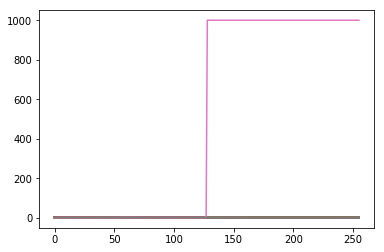

In [112]:
np.array(full_data[-1:]).shape
test = np.repeat(full_data[-1:], 2, 0)

test.shape
test = test[:, :256, :]
watch(test[0])
test[0][mask[0] == 0] = 1000
mask = np.repeat(control_mask(128), 2, 0)

out = network.predict([test, mask])

watch(out[0])
plt.plot(mask[0])
plt.plot(test[0][:, -2])
plt.plot(out[1][:, -2])

In [113]:
out[1] - out[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [198]:
network.save("decent_predictor_model")
disc_network.save("decent_discriminator_network")